In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


#Copy all files

In [3]:
!cp "/content/gdrive/MyDrive/object_detection" -a "/content/"

#Download dataset

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

#Extract data and remove tar file

In [ ]:
!tar xvf VOCtrainval_11-May-2012.tar
!rm VOCtrainval_11-May-2012.tar

In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import object_detection
from object_detection.tools import *
from object_detection.models import yolo_v2, CustomLearningRateScheduler, lr_schedule
from object_detection.constants import *

In [6]:
import object_detection
from object_detection.tools import parse_annotation

train_image_folder = "/content/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "/content/VOCdevkit/VOC2012/Annotations/"

LABELS = [
    'aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
    'bus',        'car',      'cat',  'chair',     'cow',
    'diningtable','dog',    'horse',  'motorbike', 'person',
    'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'
]

train_images, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, LABELS)
print(len(train_images))

17125


In [7]:
from object_detection.tools import SimpleBatchGenerator
from object_detection.constants import generator_config

train_batch_generator = SimpleBatchGenerator(
    train_images, generator_config, 
    norm=lambda x: x/255., shuffle=True
    )

x_batch, [y_batch, b_batch] = train_batch_generator.__getitem__(0)
print("x_batch shape = {}".format(x_batch.shape))
print("y_batch shape = {}".format(y_batch.shape))
print("b_batch shape = {}".format(b_batch.shape))

x_batch shape = (4, 416, 416, 3)
y_batch shape = (4, 13, 13, 4, 25)
b_batch shape = (4, 1, 1, 1, 50, 4)


igrid_h= 4, igrid_w= 5, iAnchor= 0, sheep
igrid_h= 5, igrid_w= 6, iAnchor= 0, sheep
igrid_h= 5, igrid_w= 8, iAnchor= 0, sheep
igrid_h= 6, igrid_w= 4, iAnchor= 1, sheep
igrid_h= 6, igrid_w= 8, iAnchor= 0, sheep
igrid_h= 6, igrid_w=11, iAnchor= 0, sheep
igrid_h= 7, igrid_w= 6, iAnchor= 1, sheep
igrid_h= 8, igrid_w= 5, iAnchor= 1, sheep


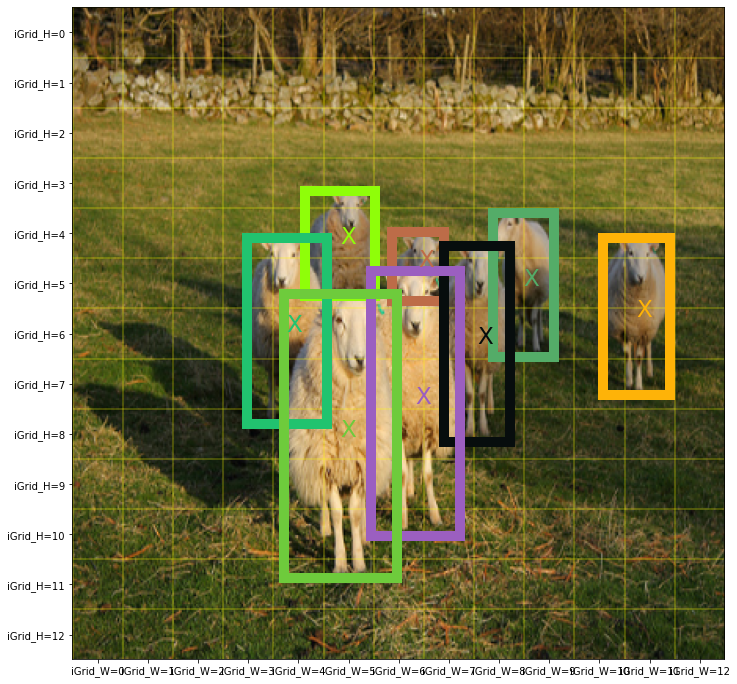

In [8]:
from object_detection.tools import *

iframe = 1
check_object_in_grid_anchor_pair(iframe, y_batch)
plot_image_with_grid_cell_partition(iframe, x_batch)
plot_grid(iframe, y_batch)

#Create model

In [9]:
from object_detection.models import yolo_v2

yolo_model = yolo_v2()
print(yolo_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 416, 416, 32  128         ['conv_1[0][0]']                 
                                )                                                             

#Download weight file

In [10]:
! wget https://pjreddie.com/media/files/yolov2.weights

--2022-05-03 14:23:36--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  23.1MB/s    in 9.1s    

2022-05-03 14:23:46 (21.3 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



In [15]:
path_to_weight = "./yolov2.weights"

print("Conv_1 shape = {}".format(
    yolo_model.get_layer('conv_1').get_weights()[0].shape))

weight_reader = WeightReader(path_to_weight)
print("All weights shape = ", weight_reader.all_weights.shape)

Conv_1 shape = (3, 3, 3, 32)
All weights shape =  (50983565,)


In [17]:
weight_reader.reset()
conv_number = 23

for i in range(1, conv_number + 1):
    conv_layer = yolo_model.get_layer('conv_' + str(i))

    if i < conv_number:
        norm_layer = yolo_model.get_layer('norm_' + str(i))
        size = np.prod(norm_layer.get_weights()[0].shape)
        
        beta = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean = weight_reader.read_bytes(size)
        var = weight_reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma, beta, mean, var])
    
    if len(conv_layer.get_weights()) > 1:
        bias = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2, 3, 1, 0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2, 3, 1, 0])
        conv_layer.set_weights([kernel])


In [19]:
last_conv_layer = yolo_model.layers[-2]
weights = last_conv_layer.get_weights()
print(weights[0].shape)
new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
new_bias = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)
last_conv_layer.set_weights([new_kernel, new_bias])

(1, 1, 1024, 100)


#Compile the model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from object_detection.loss import custom_yolo_loss

early_stop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=3,
    mode='min',
    verbose=1
)

checkpoint = ModelCheckpoint(
    "/content/gdrive/MyDrive/cv_data/yolo_v2/weights_yolo_on_voc_2012.h5",
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

optimizer = Adam(
    learning_rate=.5e-4,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8,
    decay=0.9
)

yolo_model.compile(loss=custom_yolo_loss, optimizer=optimizer)

#Train the model

In [24]:
tf.config.run_functions_eagerly(True)

history = yolo_model.fit(
    train_batch_generator,
    steps_per_epoch=len(train_batch_generator),
    epochs=15,
    verbose=1,
    callbacks=[CustomLearningRateScheduler(lr_schedule),
               early_stop, checkpoint],
    max_queue_size=3
)


Epoch: 00000, Learning rate: 0.0100
Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


  12/4282 [..............................] - ETA: 11:58:36 - loss: 61.9264

KeyboardInterrupt: ignored

In [26]:
image_reader = ImageReader(IMAGE_H, IMAGE_W, norm=lambda img: img/255.)
out = image_reader.fit(train_image_folder + "/2007_005430.jpg")
X_test = tf.expand_dims(out, 0)
y_pred = yolo_model.predict(X_test)
net_out = y_pred[0]
output_rescaler = OutputRescaler(anchors=ANCHORS)
net_out_scaled = output_rescaler.fit(net_out)
boxes = find_high_class_probability_bbox(net_out_scaled, OBJ_THRESHOLD)

print("\nobj_threshold={}".format(OBJ_THRESHOLD))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),OBJ_THRESHOLD))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "



obj_threshold=0.5
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 0 bounding boxes with top class probability > 0.5


/content/object_detection/tools.py:359: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))
/content/object_detection/tools.py:407: RuntimeWarning: overflow encountered in exp
  netout[..., 2] = (np.exp(netout[..., 2]) * mat_anchor_w) / grid_w     # width
/content/object_detection/tools.py:408: RuntimeWarning: overflow encountered in exp
  netout[..., 3] = (np.exp(netout[..., 3]) * mat_anchor_h) / grid_h     # height


Plot with high object threshold


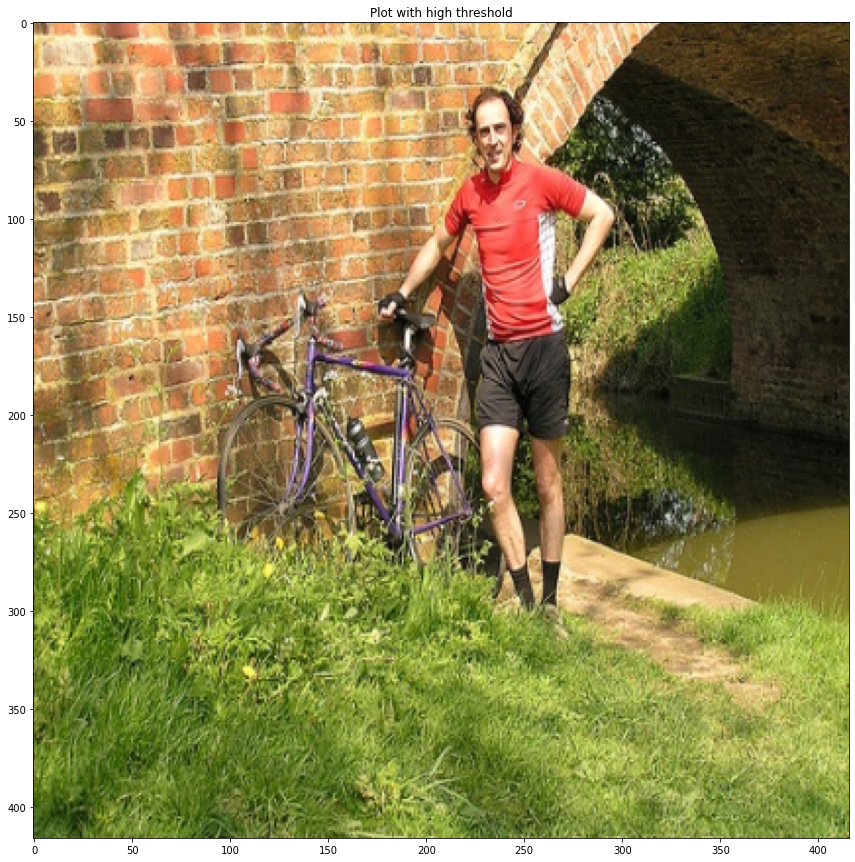

In [29]:
print("Plot with high object threshold")
figsize=(15, 15)
ima = draw_box(X_test[0].numpy(), boxes, LABELS, verbose=True)
plt.figure(figsize=figsize)
plt.imshow(ima)
plt.title("Plot with high threshold")
plt.show()